<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/BTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!gdown 1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
!gdown 1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 151, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 203, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'


In [100]:
import gdown
gdown.download('https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw', 'images.npy', quiet=False)
gdown.download('https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx', 'tip.npy', quiet=False)

Downloading...
From: https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
To: /content/images.npy
84.2kB [00:00, 2.63MB/s]
Downloading...
From: https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
To: /content/tip.npy
84.2kB [00:00, 2.67MB/s]


'tip.npy'

In [114]:
import numpy as np
images = np.load('/content/images.npy')
tip = np.load('/content/tip.npy')
surfaces = np.load('/content/surfs.npy')

In [115]:
import torch


def compute_xc_yc(tip):
    tip_xsiz, tip_ysiz = tip.size()
    xc = round(tip_xsiz / 2)
    yc = round(tip_ysiz / 2)
    return xc, yc


def idilation(surface, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    surface = surface.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    surf_xsiz, surf_ysiz = surface.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.zeros_like(surface)

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the dilation operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(surface, shifts=(-px, -py), dims=(0, 1))
            temp = temp + tip[xc + px, yc + py]
            r = torch.max(r, temp)

    return r


def ierosion(image, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    im_xsiz, im_ysiz = image.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(image, float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the erosion operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(image, shifts=(px, py), dims=(0, 1))
            temp = temp - tip[xc + px, yc + py]
            r = torch.min(r, temp)

    return r


def translate_tip_mean(P, cutoff=10**(-8)):
    # Ensure P is on GPU
    P = P.to('cuda' if torch.cuda.is_available() else 'cpu')

    tip_xsiz, tip_ysiz = P.size()
    xc, yc = compute_xc_yc(P)

    #p_max = torch.min(P)
    #P = P - p_max

    p_min = torch.min(P)
    weight = P - p_min
    weight = weight

    id = weight < cutoff
    weight[id] = 0.0

    if torch.all(weight < 10**(-10)):
        print('called')
        weight.fill_(1.0)

    ix = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    iy = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    ix = torch.cumsum(ix, dim=0) - 1.0
    iy = torch.cumsum(iy, dim=1) - 1.0
    com_x = torch.sum(ix * weight / torch.sum(weight))
    com_y = torch.sum(iy * weight / torch.sum(weight))
    id_x = round(com_x.item())
    id_y = round(com_y.item())

    pxmin = max(- xc, - id_x)
    pymin = max(- yc, - id_y)
    pxmax = min(tip_xsiz - xc, tip_xsiz - id_x)
    pymax = min(tip_ysiz - yc, tip_ysiz - id_y)

    print(id_x, id_y)
    P_new = torch.full_like(P, p_min.item())
    P_new[(xc + pxmin):(xc + pxmax), (yc + pymin):(yc + pymax)] = P[(id_x + pxmin):(id_x + pxmax), (id_y + pymin):(id_y + pymax)]

    return P_new


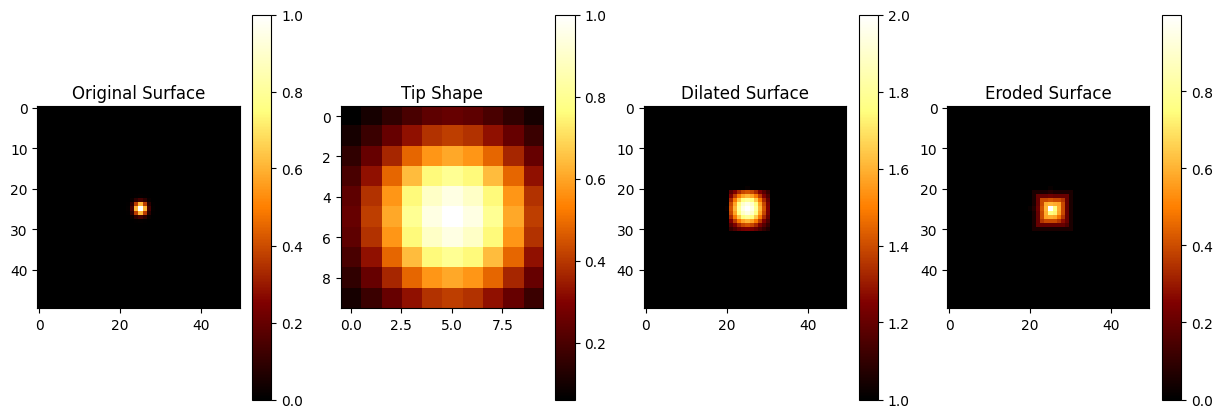

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(x_size, y_size, x_mean, y_mean, x_sigma, y_sigma):
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)
    return np.exp(-((x - x_mean) ** 2 / (2 * x_sigma ** 2) + (y - y_mean) ** 2 / (2 * y_sigma ** 2)))

# Sample surface and tip
surface_size = (50, 50)
tip_size = (10, 10)

surface = gaussian_2d(surface_size[0], surface_size[1], surface_size[0] / 2, surface_size[1] / 2, 1, 1)
tip = gaussian_2d(tip_size[0], tip_size[1], tip_size[0] / 2, tip_size[1] / 2, 3, 3)

# Convert to torch tensors
surface_tensor = torch.tensor(surface, dtype=torch.float32)
tip_tensor = torch.tensor(tip, dtype=torch.float32)

# Perform dilation
dilated_surface = idilation(surface_tensor, tip_tensor)

# Perform erosion
eroded_surface = ierosion(dilated_surface, tip_tensor)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(surface, cmap='afmhot')
plt.title('Original Surface')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(tip, cmap='afmhot')
plt.title('Tip Shape')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(dilated_surface.cpu().numpy(), cmap='afmhot')
plt.title('Dilated Surface')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(eroded_surface.cpu().numpy(), cmap='afmhot')
plt.title('Eroded Surface')
plt.colorbar()

plt.show()

In [112]:
surface = surfaces[1, :, :]
image = images[1, :, :]

In [125]:
import torch
import torch.optim as optim
import numpy as np

surface_size = surface.shape
tip_size = tip.shape
surface_tensor = torch.tensor(surface, dtype=torch.float32)

tip0 = tip
tip0_tensor = torch.tensor(tip0, dtype=torch.float32)
dilated0_surface = idilation(surface_tensor, tip0_tensor)

# Initialize tip with random values
tip_tensor = torch.zeros(tip_size, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 1000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    dilated_surface = idilation(surface_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((dilated0_surface - dilated_surface) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
optimized_tip = tip_tensor.detach().numpy()


Iteration 0, Loss: 6.097305774688721
Iteration 10, Loss: 3.8779959678649902
Iteration 20, Loss: 2.3126347064971924
Iteration 30, Loss: 1.3099390268325806
Iteration 40, Loss: 0.7200931906700134
Iteration 50, Loss: 0.3914484679698944
Iteration 60, Loss: 0.2145833671092987
Iteration 70, Loss: 0.12077503651380539
Iteration 80, Loss: 0.07069549709558487
Iteration 90, Loss: 0.043458521366119385
Iteration 100, Loss: 0.027525758370757103
Iteration 110, Loss: 0.01772948168218136
Iteration 120, Loss: 0.011636846698820591
Iteration 130, Loss: 0.007652404718101025
Iteration 140, Loss: 0.005082688760012388
Iteration 150, Loss: 0.003417112398892641
Iteration 160, Loss: 0.0023262316826730967
Iteration 170, Loss: 0.001610392238944769
Iteration 180, Loss: 0.0011401560623198748
Iteration 190, Loss: 0.0008256030851043761
Iteration 200, Loss: 0.0006237561465241015
Iteration 210, Loss: 0.00046752410707995296
Iteration 220, Loss: 0.0004982353420928121
Iteration 230, Loss: 0.00037457869620993733
Iteration 24

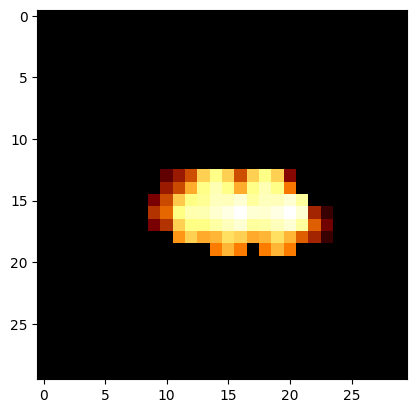

In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.imshow(dilated0_surface.cpu(), cmap='afmhot')

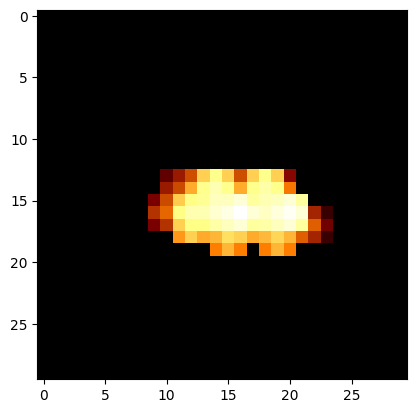

In [127]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

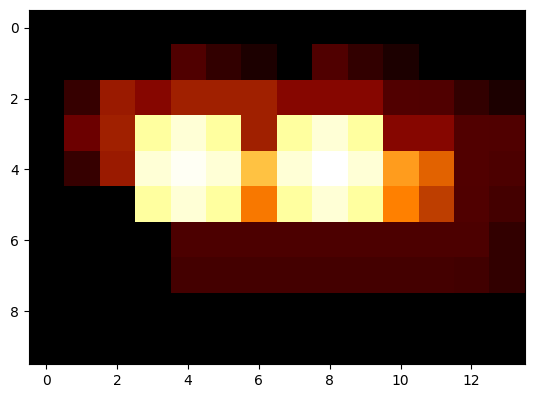

In [128]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(optimized_tip, cmap='afmhot')

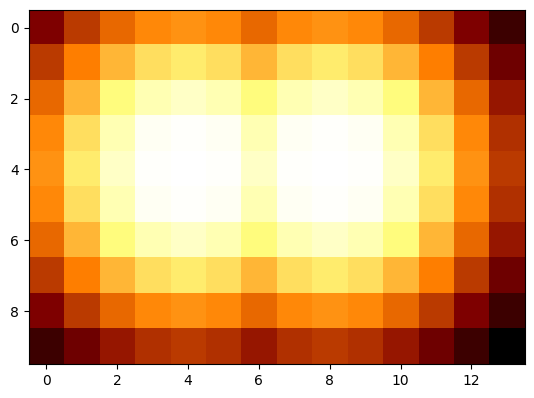

In [129]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip0, cmap='afmhot')

In [130]:
tip.shape

(10, 14)

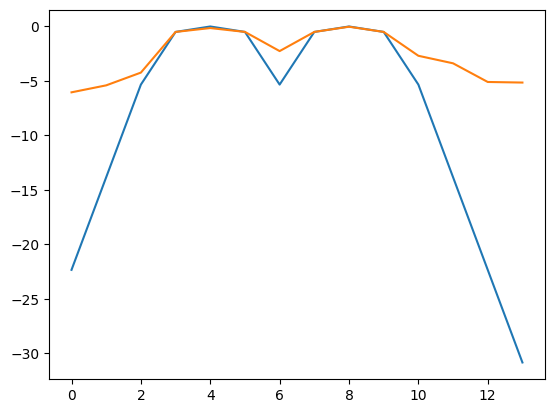

In [131]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.plot(tip0_tensor[4, :].numpy())
plt.plot(optimized_tip[4, :])

In [143]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
import copy

lambda_my = 0.00001
learning_rate_my = 0.1
nepoch = 100

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

# CustomModelを作成
class CustomModel(torch.nn.Module):
    def __init__(self, ny, nx, initial_tip):
        super(CustomModel, self).__init__()
        self.P = torch.nn.Parameter(initial_tip)

    def forward(self, x):
        return iopen(x, self.P)  # Assuming iopen is a function that operates on x using self.P

m = CustomModel(ny, nx, torch.tensor(tip, dtype=torch.float32))
optimizer = AdamW(m.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=lambda)

def loss_fn(images2, images1):
    return torch.mean(torch.nn.functional.mse_loss(m(images2), images1, reduction='none'))

loss_train = []
for epoch in range(nepoch):
    for x in data_loader:
        optimizer.zero_grad()
        y = copy(x)
        loss = loss_fn(x, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            m.P.data = torch.clamp(m.P, max=0.0)
            m.P.data = translate_tip_mean(m.P)  # Assuming translate_tip_mean is implemented

    loss_train.append(loss_fn(images_copy, images).item())

tip_estimate = m.P.detach().numpy()

SyntaxError: invalid syntax (<ipython-input-143-d2e193f04054>, line 39)